<a href="https://colab.research.google.com/github/amansandhu408/deep-learning/blob/main/24_27_xethru_v2_96_83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image


2026-02-10 09:06:13.342339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770714373.485721      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770714373.526391      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770714373.879831      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770714373.879894      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770714373.879898      55 computation_placer.cc:177] computation placer alr

In [ ]:
ROOT = "/kaggle/input/spectrograms/spectrograms"

PATH_24 = os.path.join(ROOT, "24GHz")
PATH_77 = os.path.join(ROOT, "77GHz")
PATH_XE = os.path.join(ROOT, "Xethru")

IMG_SIZE = 224
VALID_EXT = (".png", ".jpg", ".jpeg", ".bmp")

In [ ]:
CLASSES = sorted(os.listdir(PATH_24))
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)

Classes: ['bending', 'crawling', 'kneeling', 'limping', 'picking_up_object', 'scissors_gait', 'short_steps', 'sitting', 'walking_away_from_radar', 'walking_on_both_toes', 'walking_towards_radar']


In [ ]:
CLASSES = sorted(os.listdir(PATH_77))
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)

Classes: ['bending', 'crawling', 'kneeling', 'limping', 'picking_up_object', 'scissors_gait', 'short_steps', 'sitting', 'walking_away_from_radar', 'walking_on_both_toes', 'walking_towards_radar']


In [ ]:
CLASSES = sorted(os.listdir(PATH_XE))
NUM_CLASSES = len(CLASSES)

print("Classes:", CLASSES)

Classes: ['bending', 'crawling', 'kneeling', 'limping', 'picking_up_object', 'scissors_gait', 'short_steps', 'sitting', 'walking_away_from_radar', 'walking_on_both_toes', 'walking_towards_radar']


In [ ]:
def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()
        return True
    except:
        return False


def load_three_radar_data(p1, p2, p3, classes):
    X1, X2, X3, Y = [], [], [], []

    for label, cls in enumerate(classes):
        d1, d2, d3 = os.path.join(p1, cls), os.path.join(p2, cls), os.path.join(p3, cls)

        f1 = sorted([f for f in os.listdir(d1) if f.lower().endswith(VALID_EXT)])
        f2 = sorted([f for f in os.listdir(d2) if f.lower().endswith(VALID_EXT)])
        f3 = sorted([f for f in os.listdir(d3) if f.lower().endswith(VALID_EXT)])

        for a, b, c in zip(f1, f2, f3):
            p_1, p_2, p_3 = os.path.join(d1, a), os.path.join(d2, b), os.path.join(d3, c)

            if not (is_valid_image(p_1) and is_valid_image(p_2) and is_valid_image(p_3)):
                continue

            X1.append(np.array(Image.open(p_1).resize((IMG_SIZE, IMG_SIZE))) / 255.0)
            X2.append(np.array(Image.open(p_2).resize((IMG_SIZE, IMG_SIZE))) / 255.0)
            X3.append(np.array(Image.open(p_3).resize((IMG_SIZE, IMG_SIZE))) / 255.0)
            Y.append(label)

    return np.array(X1), np.array(X2), np.array(X3), np.array(Y)

In [ ]:
X24, X77, XE, y = load_three_radar_data(PATH_24, PATH_77, PATH_XE, CLASSES)
Y = to_categorical(y, NUM_CLASSES)

X24_tr, X24_val, X77_tr, X77_val, XE_tr, XE_val, y_tr, y_val = train_test_split(
    X24, X77, XE, Y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
def create_encoder(name):
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return models.Model(base.input, x, name=name)

In [ ]:
def attention_fusion(f24, f77, fXE):
    a24 = layers.Dense(1, activation="sigmoid")(f24)
    a77 = layers.Dense(1, activation="sigmoid")(f77)
    aXE = layers.Dense(1, activation="sigmoid")(fXE)

    s = layers.Add()([a24, a77, aXE])

    w24 = layers.Lambda(lambda x: x[0] / x[1])([a24, s])
    w77 = layers.Lambda(lambda x: x[0] / x[1])([a77, s])
    wXE = layers.Lambda(lambda x: x[0] / x[1])([aXE, s])

    f24 = layers.Multiply()([f24, w24])
    f77 = layers.Multiply()([f77, w77])
    fXE = layers.Multiply()([fXE, wXE])

    return layers.Add()([f24, f77, fXE])

In [ ]:
def classifier_block(x):
    x = layers.Dense(256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)

    return layers.Dense(NUM_CLASSES, activation="softmax")(x)

In [ ]:
def build_model(hp):

    encoder_24 = create_encoder("enc_24")
    encoder_77 = create_encoder("enc_77")
    encoder_xe = create_encoder("enc_xe")

    in24 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    in77 = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    inXE = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Noise robustness (paper-inspired)
    n24 = layers.GaussianNoise(0.02)(in24)
    n77 = layers.GaussianNoise(0.02)(in77)
    nXE = layers.GaussianNoise(0.02)(inXE)

    f24 = encoder_24(n24)
    f77 = encoder_77(n77)
    fXE = encoder_xe(nXE)

    fused = attention_fusion(f24, f77, fXE)

    # ----------- 3 Dense Layers (tuned) -----------
    x = layers.Dense(
        hp.Choice("dense1", [256, 384, 512]),
        use_bias=False
    )(fused)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(hp.Float("dropout1", 0.3, 0.5, step=0.1))(x)

    x = layers.Dense(
        hp.Choice("dense2", [128, 256]),
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(hp.Float("dropout2", 0.2, 0.4, step=0.1))(x)

    x = layers.Dense(
        hp.Choice("dense3", [64, 128]),
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = models.Model([in24, in77, inXE], out)

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=hp.Float("lr", 1e-4, 1e-3, sampling="log"),
        weight_decay=5e-4
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )

    return model


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=12,
    directory="radspecfusion_tuner",
    project_name="mobilenetv2_attention",
    overwrite=True
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

I0000 00:00:1770714446.936462      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770714446.942168      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
tuner.search(
    [X24_tr, X77_tr, XE_tr],
    y_tr,
    validation_data=([X24_val, X77_val, XE_val], y_val),
    epochs=10,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

Trial 12 Complete [00h 01m 38s]
val_accuracy: 0.89682537317276

Best val_accuracy So Far: 0.9126983880996704
Total elapsed time: 00h 20m 19s


In [ ]:
best_model = tuner.get_best_models(1)[0]

best_model.summary()

history = best_model.fit(
    [X24_tr, X77_tr, XE_tr],
    y_tr,
    validation_data=([X24_val, X77_val, XE_val], y_val),
    epochs=50,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9530 - loss: 0.7946 - val_accuracy: 0.8730 - val_loss: 0.9597
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9353 - loss: 0.7595 - val_accuracy: 0.8651 - val_loss: 0.9561
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9523 - loss: 0.7094 - val_accuracy: 0.8810 - val_loss: 0.8689
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9558 - loss: 0.7212 - val_accuracy: 0.9206 - val_loss: 0.8054
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9798 - loss: 0.6869 - val_accuracy: 0.9286 - val_loss: 0.7954
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9714 - loss: 0.7064 - val_accuracy: 0.9127 - val_loss: 0.8058
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9627 - loss: 0.6906 - val_accuracy: 0.9286 - val_loss: 0.7741
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9871 - loss: 0.6567 - val_accuracy: 0.9127 - va

In [ ]:
loss, acc = best_model.evaluate(
    [X24_val, X77_val, XE_val],
    y_val,
    verbose=0
)

print(f"Validation (Test) Accuracy: {acc * 100:.2f}%")


2026-02-10 09:41:00.956482: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-10 09:41:01.093066: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-10 09:41:14.813447: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-10 09:41:14.951139: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Validation (Test) Accuracy: 96.83%


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


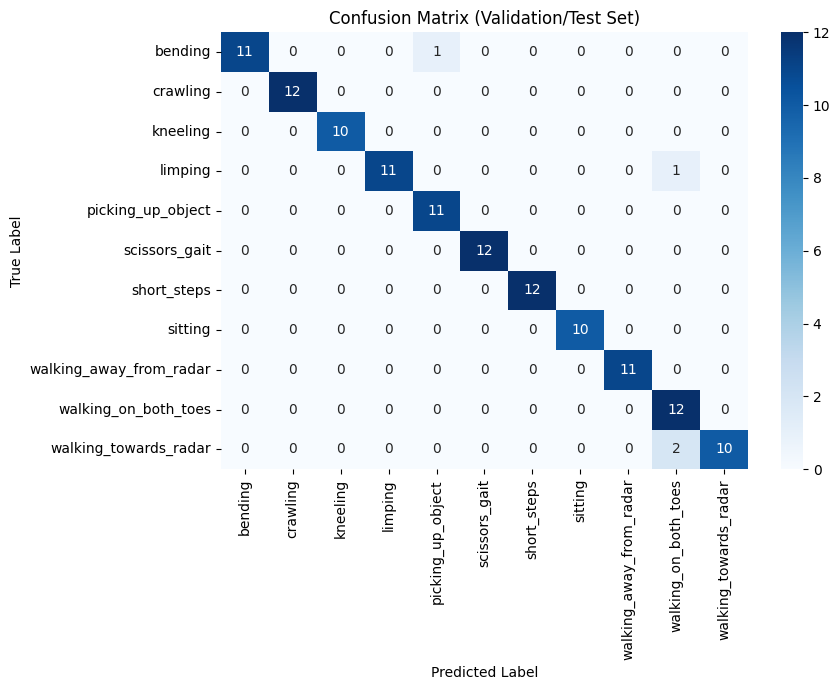

In [ ]:
import numpy as np

y_pred = best_model.predict([X24_val, X77_val, XE_val])
y_pred_cls = np.argmax(y_pred, axis=1)
y_true_cls = np.argmax(y_val, axis=1)



from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_cls, y_pred_cls)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation/Test Set)")
plt.tight_layout()
plt.show()

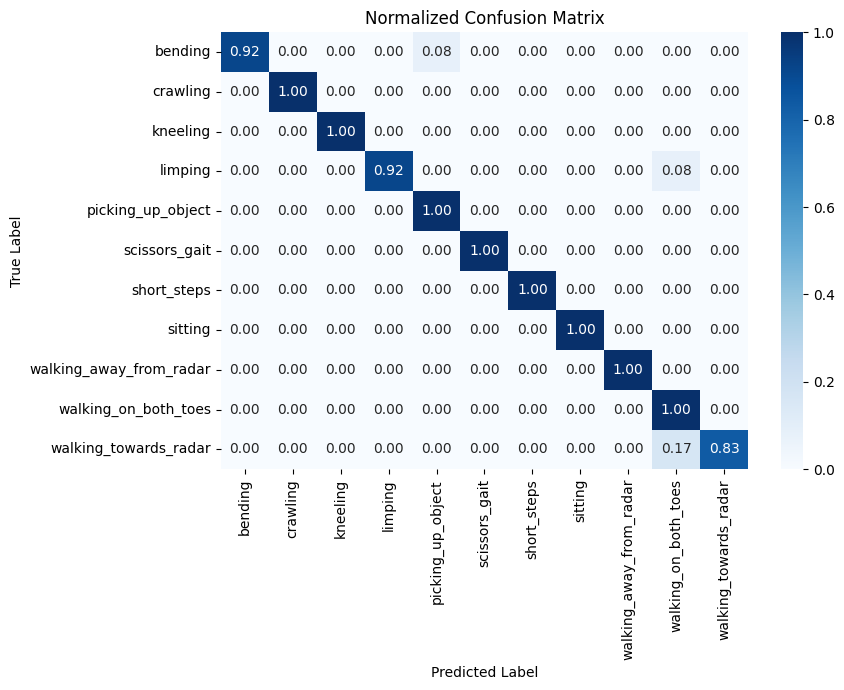

In [ ]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Feature shape: (126, 64)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


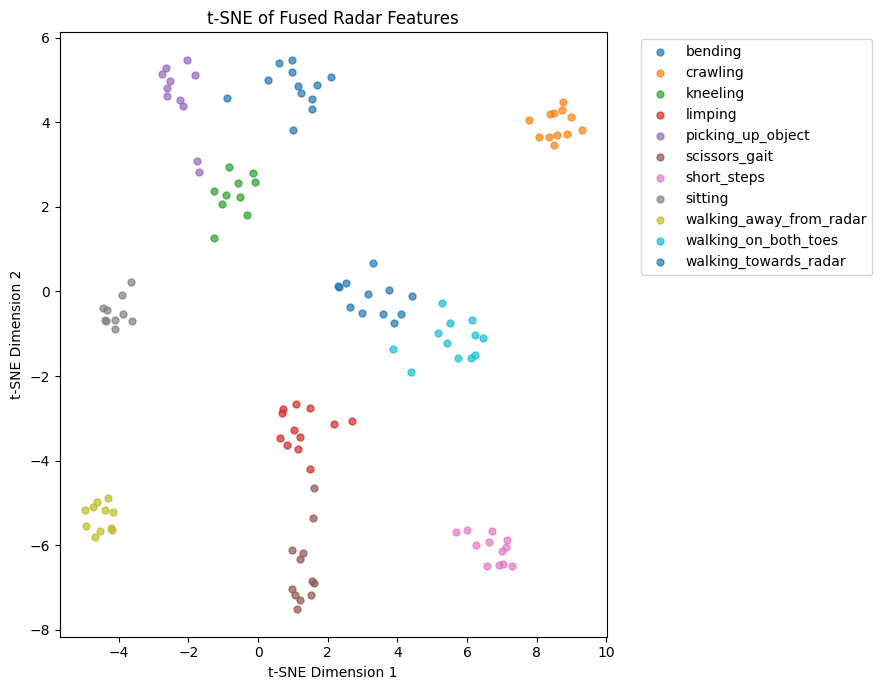

In [ ]:
# Take the layer just before the final softmax
feature_layer = best_model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=best_model.inputs,
    outputs=feature_layer
)

features = feature_extractor.predict(
    [X24_val, X77_val, XE_val],
    batch_size=16,
    verbose=1
)

print("Feature shape:", features.shape)


from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

features_2d = tsne.fit_transform(features)


plt.figure(figsize=(9, 7))

for class_id, class_name in enumerate(CLASSES):
    idx = y_true_cls == class_id
    plt.scatter(
        features_2d[idx, 0],
        features_2d[idx, 1],
        label=class_name,
        s=25,
        alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("t-SNE of Fused Radar Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()